# Exercises: neural network review/introduction

Exercise on classification using NN. 

Author: Stefano Pagani <stefano.pagani@polimi.it>.

Date: 2024

Course: Mathematical and numerical foundations of scientific machine learning.

Example adapted from:
[1] Brunton, S. L., & Kutz, J. N. (2022).
Data-driven science and engineering: Machine learning,
dynamical systems, and control. Cambridge University Press.
Data from [1].


In [176]:

# Import modules

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import io
import os
from sklearn import linear_model
import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras import regularizers
from keras.utils import to_categorical



In [177]:
# Read dataset
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [9, 6]

dogdata_mat = io.loadmat(os.path.join('dogData.mat'))
catdata_mat = io.loadmat(os.path.join('catData.mat'))

# Extract data from mat file 
dog = dogdata_mat['dog']
cat = catdata_mat['cat']

# Concatenate in 1D vector
CD = np.concatenate((dog,cat),axis=1)

# Split data into training and validation dataset
# Input data
X_train = np.concatenate((dog[:,:60],cat[:,:60]),axis=1) 
X_test = np.concatenate((dog[:,60:80],cat[:,60:80]),axis=1) 

# Labels (truth)
y_train = np.repeat(np.array([1,-1]),60) 
y_test = np.repeat(np.array([1,-1]),20)




Task 1: visualize some pictures from the training set

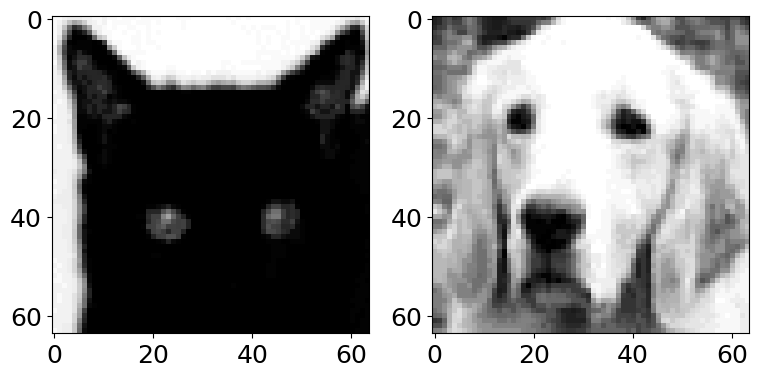

In [178]:
# Create figure subplot
plt.figure()
figplot1 = plt.subplot(1, 2,1)

figplot2 = plt.subplot(1,2,2)

# Select image
imgID = 33

# Show image
figplot1.imshow(np.reshape(cat[:, imgID], (64, 64)).T, cmap='gray')
figplot2.imshow(np.reshape(dog[:, imgID], (64, 64)).T, cmap='gray')
plt.show()




Task 2: we can formulate the problem as a least-squares problem of minimizing norm(X_trian x-y_train). Suggestion: use the Moore-Penrose Pseudoinverse.

In [179]:
## TEST LS (L2 NORM) WITHOUT REGULARIZATION

# Define A matrix solving the problem in LS sense
#linRegrObj = linear_model.LinearRegression.fit(X_train, y_train)
# Nope: use np pinv with X train and y_train

estimL2noReg = np.linalg.pinv(X_train.T) @ y_train # TO DO: check what pinv does in numpy doc

# IMPORTANT: the Least Squares problem here must be considered as "regression" used for classification 
# The input data matrix constitutes the model of the problem (regressors).
# A is the solution of the problem obtained by solving X^-1*y with an appropriate Linear Algebra method (e.g. pinv)
# Specifically, the data matrix contains one image of cats/dogs per column.

# Check the sign of the output on the X_test dataset
# EXPLANATION: The sign indicates whether the classification model considers each column (image) 
# as a cat or as a dog (either 1 or -1). The linear regression over the pixels basically determines 
# a "hyperline" which dimension equal to the number of pixels (the A estimator). The application of A
# to new data X_test evaluates ("classify") whether each new pixel column in X_test is near "dog" or "cat".
# The clear limitation: the model is linear and is not really capable of classifying complex image contents.
# Recall that this is infact what Lovera showed as introduction to ML during ELA 2022/2023 course.

validationOutputLabelsL2 = np.sign( estimL2noReg @ X_test ) 

# TO DO: how to distinguish whether 1 and -1 correspond to cat and dogs?
# See labels: cat=1, dog=-1

truthValues = np.concatenate((np.ones(20), -np.ones(20)), axis=0)
print(validationOutputLabelsL2)

# Lambda function syntax: lambda input1, input2: function_implementation_line
computeAccuracyPerc = lambda validationOutputLabels: 100 * (np.sum((truthValues - validationOutputLabels) == 0))/len(truthValues)

# Compute error percentage
correctPercL2 = computeAccuracyPerc(validationOutputLabelsL2)


[ 1.  1. -1. -1. -1.  1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.
 -1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
  1. -1. -1. -1.]



Task 3: we can formulate the problem as a least-squares problem plus a $\ell_1$ regularization (Lasso). Suggestion: use the command linear_model.Lasso(alpha=0.1).

In [180]:
## TEST LS (L2 NORM) USING LASSO REGULARIZATION
# TO DO: check what Lasso regularization does
alphaParam = 0.4
regressorL2Lasso = linear_model.Lasso(alphaParam) # TO DO: Check what are the inputs to the model 
regressorL2Lasso.fit(X_train.T, y_train) # Note: sklearn uses the opposite convention of the data matrix: features are along columns, samples along 

regrRidge = linear_model.RidgeClassifier(alphaParam)
regrRidge.fit(X_train.T, y_train)

# Test linear classification with Lasso on the test data matrix

validationOutputLabelsLasso = np.sign(regressorL2Lasso.predict(X_test.T)) # Make inference over data set using L2Lasso regressor
validationOutputLabelsRigde = np.sign(regrRidge.predict(X_test.T)) # Make inference over data set using L2Lasso regressor

# Compute accuracy of Lasso regression for classification
correctPercLasso = computeAccuracyPerc(validationOutputLabelsLasso) 
correctPercRidge = computeAccuracyPerc(validationOutputLabelsRigde) 

'Accuracy scores: \n Non-regularized L2: {:3.2f} \n Ridge regression (L2 with Tikhonov): {:3.2f} \n Lasso regression (L2 with L1 regularization): {:3.2f}'.format(correctPercL2, correctPercLasso, correctPercRidge)


'Accuracy scores: \n Non-regularized L2: 67.50 \n Ridge regression (L2 with Tikhonov): 70.00 \n Lasso regression (L2 with L1 regularization): 67.50'


Task 3: implement a single layer (two neurons) neural network to classify the pictures.

In [181]:
# Keras NN
from keras.models import Sequential   # importing Sequential model
from keras.layers import Dense        # importing Dense layers

# Prepare input train and test data by normalizing the input values (256 is the maximum value in 8 bits images)
X_tf_train = tf.constant(  np.transpose(X_train)/256, dtype = tf.float32 )
X_tf_validation = tf.constant( np.transpose(X_test)/256, dtype = tf.float32 )

y = np.array([[1,0],[0,1]])

y_tf_train = tf.constant( np.repeat(y, [60, 60], axis=0) , dtype = tf.float32 )

y_tf_validation = tf.constant( np.repeat(y, [20, 20], axis=0) , dtype = tf.float32 )


In [184]:
# Provided solution
solutionModel = Sequential()

# Adding layers to the model
solutionModel.add(Dense(units = 2 , activation = 'softmax', input_shape = (64*64,)))#kernel_regularizer = regularizers.l1(0.0025)))

sgd = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
solutionModel.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

# training the model
solutionModel.fit(X_tf_train, y_tf_train, epochs=250)

# Initialize NN model instance
DNNclassifier_model = keras.Sequential()
# Adding layers to the model
# DNNclassifier_model.add(Dense(  ...   ))
# Specify architecture by adding layers and setting hyperparameters (type of activate, number of nodes)
# Input Layer I0
input_size = np.shape(X_tf_train)[1]
DNNclassifier_model.add(layers.Dense(units = 2, input_shape=(input_size,), activation='softmax'))

# Hidden Layer H1
#DNNclassifier_model.add(layers.Dense(4, activation='softmax'))

# Hidden Layer H2
#DNNclassifier_model.add(layers.Dense(np.shape(X_tf_train)[1]/4, activation='relu'))

# Output Layer O3 --> output must be [2,1] even though it is not the most efficient way
# Try to modify the train and validation dataset to use the latter way
#DNNclassifier_model.add(layers.Dense(2, activation='softmax'))

# Compile model (Set optimizer type, e.g. Adam)
#DNNclassifier_model.compile(loss = ... )
sgd = keras.optimizers.SGD(learning_rate=0.1, momentum=0.8, nesterov=True)
DNNclassifier_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

keras.utils.plot_model(
    DNNclassifier_model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False,
)

# Train model using Keras optimizer
# NOTE: This is not stritly necessary. The model may be optimized by using other libraries depending
# on which solvers are available and their performance (suggestion by Davide)
DNNclassifier_model.fit(X_tf_train, y_tf_train, epochs=150)

# Compute accuracy metrics on validation dataset
loss_and_metrics = DNNclassifier_model.evaluate(X_tf_validation, y_tf_validation)
print('Loss = ',loss_and_metrics[0])
#print('Accuracy = %.2f', % (loss_and_metrics[1]*100))


Epoch 1/250
4/4 [==============================] - 0s 2ms/step - loss: 0.9408 - accuracy: 0.5500
Epoch 2/250
4/4 [==============================] - 0s 2ms/step - loss: 1.9161 - accuracy: 0.5333
Epoch 3/250
4/4 [==============================] - 0s 2ms/step - loss: 1.9359 - accuracy: 0.4000
Epoch 4/250
4/4 [==============================] - 0s 2ms/step - loss: 0.8368 - accuracy: 0.7583
Epoch 5/250
4/4 [==============================] - 0s 2ms/step - loss: 0.4065 - accuracy: 0.8667
Epoch 6/250
4/4 [==============================] - 0s 2ms/step - loss: 0.4358 - accuracy: 0.7500
Epoch 7/250
4/4 [==============================] - 0s 2ms/step - loss: 0.4871 - accuracy: 0.7667
Epoch 8/250
4/4 [==============================] - 0s 2ms/step - loss: 0.3228 - accuracy: 0.8417
Epoch 9/250
4/4 [==============================] - 0s 2ms/step - loss: 0.3023 - accuracy: 0.8417
Epoch 10/250
4/4 [==============================] - 0s 2ms/step - loss: 0.2853 - accuracy: 0.8750
Epoch 11/250
4/4 [===========

NameError: name 'test_labels' is not defined

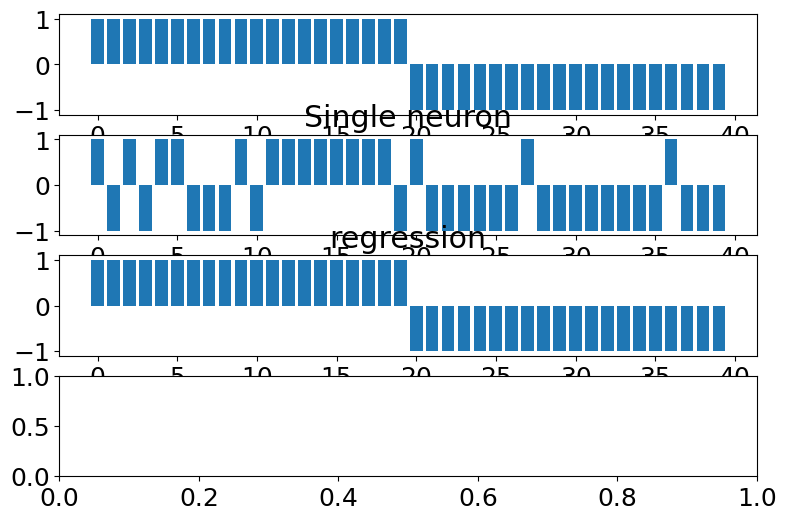

In [183]:


fig,axs = plt.subplots(4,1)
axs[0].bar(range(len(truthValues)),y_test)
NNpred = np.sign(np.array(-1.0 +2.0*DNNclassifier_model(X_tf_validation).numpy()))
#NNpred = (tf.argmax(DNNclassifier_model(X_tf_test),axis=1).numpy())
axs[1].bar(range(len(truthValues)),NNpred[:,0])
axs[1].set_title('Single neuron')
axs[2].bar(range(len(truthValues)),truthValues)
axs[2].set_title('regression')
axs[3].bar(range(len(test_labels)),test_labels_lasso)
axs[3].set_title('lasso')
plt.show()
